# put Figure 2 together

In [198]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

import numpy as np

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature



plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.labelsize'] = 'medium'

In [199]:
# locations:

loc_trop = [-20, 0]
loc_temp = [-20, 47]
rbb = 2.

trop_col = 'red'
temp_col = 'blue'

# 1. MAP

In [200]:
def locationtopoly(loc):
    lat_corners = np.array([loc[1] -rbb] + [loc[1] -rbb] + [loc[1] +rbb] + [loc[1] +rbb])
    lon_corners = np.array([loc[0] +rbb] + [loc[0] -rbb] + [loc[0] -rbb] + [loc[0] +rbb])

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    
    return poly_corners

In [255]:
def createmap(gs,fig):
    ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
    
    feature = cfeature.NaturalEarthFeature(
        name='land', category='physical',
        scale='10m',
        facecolor='#AAAAAA')
    ax1.add_feature(feature)

    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.ticker as mticker

    # taken from here: https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.3, linestyle='-')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-60,-40, -20, 0, 20])
    
    gl.xlabel_style = {'size': 20, 'color': 'gray'}
    gl.ylabel_style = {'size': 20, 'color': 'gray'}
    gl.ylabels_right = False


    ax1.plot([-55, 10], [0, 0],
             color='gray', linestyle='--',
             transform=ccrs.PlateCarree(),
             )

    ax1.plot([-55, 10], [-20, 70],
             color='gray', linestyle='--',
             transform=ccrs.PlateCarree(), alpha=0
             )

    #lat_corners = np.array([46.,  46., 48., 48.])
    #lon_corners = np.array([ -19., -21., -21., -19.]) 

    poly_corners_temp = locationtopoly(loc_temp)
    poly_corners_trop = locationtopoly(loc_trop)

    poly_trop = mpatches.Polygon(poly_corners_trop, closed=True, ec=trop_col, fill=True, lw=1, fc=trop_col)
    ax1.add_patch(poly_trop)
    poly_temp = mpatches.Polygon(poly_corners_temp, closed=True, ec=temp_col, fill=True, lw=1, fc=temp_col)
    ax1.add_patch(poly_temp)
    
    plt.text(loc_trop[0]-2, loc_trop[1]-7, 'Tropical Location',c=trop_col, size=20,
         horizontalalignment='left')
    plt.text(loc_temp[0]+2, loc_temp[1]+4.5, 'Temperate Location',c=temp_col, size=20,
         horizontalalignment='right')
    
    return ax1

# 2. Forcing

In [250]:
import sys
sys.path.append('../../phydra_OSM/')

from phydra.forcing import Forcing

class Physics:
    """"""
    def __init__(self,params,fxtype, lat, lon, rbb):
        self.parameters = params
        self.type = fxtype
        if self.type == 'slab':
            self.forcing = Forcing('WOA2018', lat, lon, rbb)
        elif self.type == 'EMPOWER':
            self.forcing = Forcing('EMPOWER', None,None,None)


    def MLD(self,t):
        return np.array([self.forcing.MLD.return_interpvalattime(t), self.forcing.MLD.return_derivattime(t)])

    def N0(self, t):
        return self.forcing.NOX.return_interpvalattime(t)

    def PAR(self, t):
        return self.forcing.PAR.return_interpvalattime(t)

    def Tmld(self, t):
        return self.forcing.SST.return_interpvalattime(t)
    
class ModelSetup:
    """"""
    def __init__(self, params, lat, lon, rbb, physx_only=False):
        if physx_only:
            self.physics = Physics(params, 'slab', lat, lon, rbb) # 'slab' as fxtype instead
        else:
            self.nutrients = StateVariables(params, 'nuts')
            self.phytoplankton = StateVariables(params, 'phyto')
            self.zooplankton = StateVariables(params, 'zoo')
            self.detritus = StateVariables(params, 'det')
            self._classes = [self.nutrients, self.phytoplankton, self.zooplankton, self.detritus]

            self.physics = Physics(params, 'slab', lat, lon, rbb)  # 'EMPOWER' / 'slab' as fxtype instead

    @property
    def classes(self):
        return self._classes

    def timestep_init(self,x):
        n = self.nutrients.num
        p = self.phytoplankton.num
        z = self.zooplankton.num
        d = self.detritus.num
        nuts = x[0:n]
        phyto = x[n:n+p]
        zoo = x[n+p:n+p+z]
        det = x[n+p+z:n+p+z+d]
        rest = x[n+p+z+d:]
        return nuts, phyto, zoo, det, rest

In [251]:
parameters = []

timedays = np.arange(0., 5 * 365., 1.0)


In [252]:
loc_temp[0]
ms1 = ModelSetup(parameters, loc_temp[1], loc_temp[0], rbb, physx_only=True) # 0, -20
ms2 = ModelSetup(parameters, loc_trop[1], loc_trop[0], rbb, physx_only=True) # 0, -20

mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created
mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created


In [253]:
def modelforcingplot(muplot, ms, gs, fig, ax1, ax2):
    fontsize = 20
    labelsize = 20
    
    culr=[temp_col,trop_col]
    
    x = muplot
    muplot = 0
    
    numcols = 2

    plt.setp((ax1, ax2), xticks=[1,60,120,180,240,300,365])
    from matplotlib.ticker import MaxNLocator
    for axe in (ax1, ax2):
        for i in range(numcols):
            axe[i].grid(True, alpha=0.5)
            axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
            axe[i].tick_params(top=False, right=True)

    # PLOTTING


    timedays_ly = timedays[1:366]


    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15

    
    
    ax2[muplot].set_xlabel('Day in year', fontsize=fontsize)
    ax2[muplot+1].set_xlabel('Day in year', fontsize=fontsize)
    
    N_Max = 10  # np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) + np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) * 0.1
  
    NOX = ms.physics.forcing.NOX.return_interpvalattime(timedays_ly)
    NOXdat = ms.physics.forcing.NOX.forcingfile
    
    
    MLD = ms.physics.forcing.MLD.return_interpvalattime(timedays_ly)
    MLDdat = ms.physics.forcing.MLD.forcingfile
    MLD_max = 250 #np.max(MLD) + 0.1 * np.max(MLD)
    #print(NOX)
    #print(NOXdat)
    
    par1 = ax1[muplot+1]

    par1.plot(timedays_ly, NOX, culr[x], lw=lws[0], alpha=alphas[0])
    par1.scatter(dpm_cumsum, NOXdat[0:12], c=culr[x])
    if x == 1:
        par1.set_ylabel('$N_0$ \n' '[µM]', multialignment='center', fontsize=fontsize)
    par1.set_ylim(0., N_Max)
    #ax1[muplot].invert_yaxis()

    ax1[muplot].plot(timedays_ly, MLD, culr[x], lw=lws[0], alpha=alphas[0])
    ax1[muplot].scatter(dpm_cumsum, MLDdat[0:12], c=culr[x])
    if x == 0:
        ax1[muplot].set_ylabel('MLD \n' '[m]', multialignment='center', fontsize=fontsize)
    ax1[muplot].set_ylim(0, MLD_max) # 400 for biotrans, 100 for Papa
    ax1[muplot].invert_yaxis()
    
    par1.yaxis.tick_right()
    par1.yaxis.set_ticks_position('both')
    par1.yaxis.set_label_position("right")
    ####################
    tkw = dict(size=5, width=1)
    ###################
    par1.tick_params(direction="in", axis='y', labelsize=labelsize, **tkw)
    #par1.yaxis.label.set_color('b')
    #par1.spines['right'].set_edgecolor('b')
   
    ax1[muplot].tick_params(direction='in', labelsize=labelsize,**tkw)
    par1.tick_params(direction='in', labelsize=labelsize,**tkw)
    
    ax1[muplot].tick_params(direction="in", axis='y', labelsize=labelsize, **tkw)
    #ax1[muplot].yaxis.label.set_color('r')
    #ax1[muplot].spines['left'].set_color('r')
    
    ##################################
    
    
    PAR = ms.physics.forcing.PAR.return_interpvalattime(timedays_ly)
    PARdat = ms.physics.forcing.PAR.forcingfile
    PAR_max = 55  # np.max(PAR) + 0.1 * np.max(PAR)
    
    Tmld = ms.physics.forcing.SST.return_interpvalattime(timedays_ly)
    Tmlddat = ms.physics.forcing.SST.forcingfile
    Tmld_max = 40  # np.max(Tmld) + 0.1 * np.max(Tmld)

    
    par2 = ax2[muplot+1]
    
    ax2[muplot].plot(timedays_ly, PAR, culr[x], lw=lws[0], alpha=alphas[0])
    ax2[muplot].scatter(dpm_cumsum, PARdat[0:12], c=culr[x])
    if x == 0:
        ax2[muplot].set_ylabel('PAR \n' '[$\mu mol$ photons $m^{−2}$ $s^{−1}$]', multialignment='center', fontsize=fontsize)
    ax2[muplot].set_ylim(0, PAR_max)
    # ax1[muplot].invert_yaxis()
    

    par2.plot(timedays_ly, Tmld, culr[x], lw=lws[0], alpha=alphas[0])
    par2.scatter(dpm_cumsum, Tmlddat[0:12], c=culr[x])
    if x == 1:
        par2.set_ylabel('$T_{MLD}$ \n' '[°C]', multialignment='center', fontsize=fontsize)
    par2.set_ylim(0, Tmld_max)
    par2.yaxis.tick_right()
    par2.yaxis.set_ticks_position('both')
    par2.yaxis.set_label_position("right")
    
        
    par2.tick_params(direction="in", axis='y', labelsize=labelsize, **tkw)
    #par2.yaxis.label.set_color('orange')
    #par2.spines['right'].set_edgecolor('orange')
   
    ax2[muplot].tick_params(direction='in', labelsize=labelsize,**tkw)
    par2.tick_params(direction='in', labelsize=labelsize,**tkw)
    
    ax2[muplot].tick_params(direction="in", axis='y', labelsize=labelsize, **tkw)
    #ax2[muplot].yaxis.label.set_color('y')
    #ax2[muplot].spines['left'].set_color('y')
    

    #ax1[muplot+1].yaxis.set_major_formatter(plt.NullFormatter())
    #ax2[muplot+1].yaxis.set_major_formatter(plt.NullFormatter())

    return [ax1, ax2]

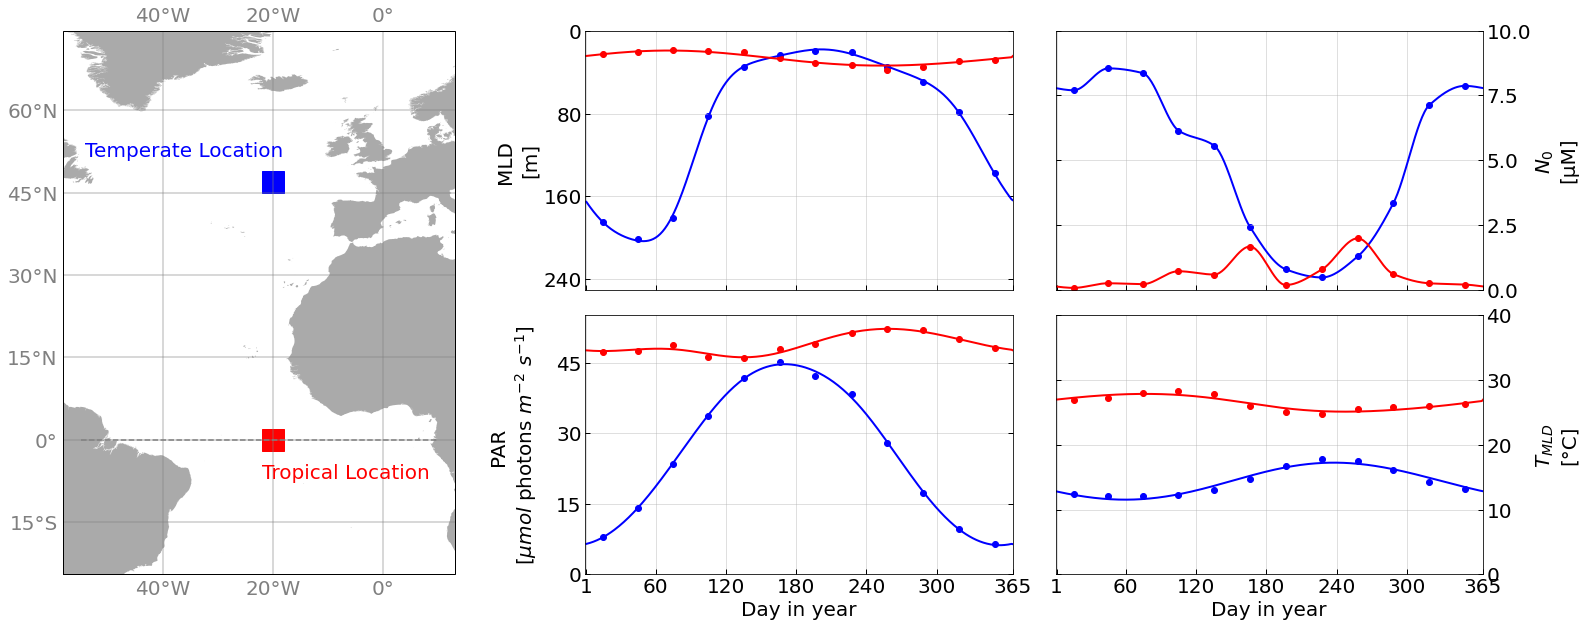

In [256]:
fig = plt.figure(constrained_layout=False)

gs1 = fig.add_gridspec(nrows=1, ncols=2, left=0.0, right=0.6, wspace=0.)
f_ax1 = fig.add_subplot(gs1[:, 0])

gs2 = fig.add_gridspec(nrows=2, ncols=3,
                        hspace=0.1, wspace=0.1, left=.05, right=1)
ax2x = fig.add_subplot(gs2[0, 1])
ax3x = fig.add_subplot(gs2[0, 2])
ax4x = fig.add_subplot(gs2[1, 1])
ax5x = fig.add_subplot(gs2[1, 2])

ax1x = createmap(gs1,fig)
modelforcingplot(0, ms1, gs2, fig, [ax2x, ax3x], [ax4x,ax5x])
modelforcingplot(1, ms2, gs2, fig, [ax2x, ax3x], [ax4x,ax5x])



ax2x.set_xticklabels([])
ax3x.set_xticklabels([])



# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax2x, ax3x, ax4x, ax5x), xlim=xlim)


fig.align_ylabels()

plt.savefig('Figure3.pdf', bbox_inches='tight')

plt.show()


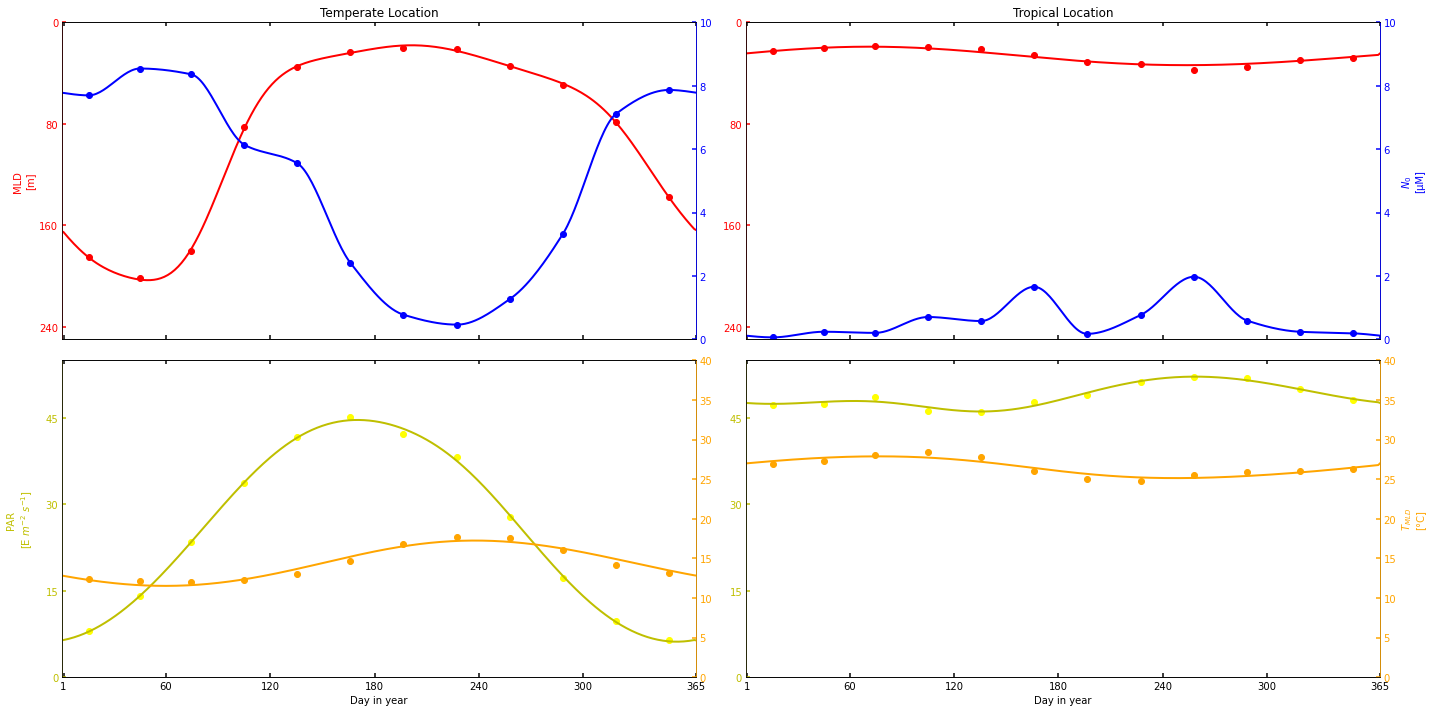

In [109]:
numcols = 2
f1, (ax1, ax2) = plt.subplots(2, numcols, sharex='col')#, sharey='row')


plt.setp((ax1, ax2), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2):
    for i in range(numcols):
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=True, right=True)

# PLOTTING


# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']
alphas = [1., 0.8, 0.6, 0.4]
lws = [2, 2.5, 4, 5.5]

timedays_ly = timedays[1:366]


dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15



## PHYSICS ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def modelforcingplot(muplot, ms):
    if muplot == 0:
        ax1[muplot].set_title('Temperate Location')
    else:
        ax1[muplot].set_title('Tropical Location')

    ax2[muplot].set_xlabel('Day in year')
    
    N_Max = 10  # np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) + np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) * 0.1
  
    NOX = ms.physics.forcing.NOX.return_interpvalattime(timedays_ly)
    NOXdat = ms.physics.forcing.NOX.forcingfile
    
    
    MLD = ms.physics.forcing.MLD.return_interpvalattime(timedays_ly)
    MLDdat = ms.physics.forcing.MLD.forcingfile
    MLD_max = 250 #np.max(MLD) + 0.1 * np.max(MLD)
    #print(NOX)
    #print(NOXdat)
    
    par1 = ax1[muplot].twinx()

    par1.plot(timedays_ly, NOX, "b-", lw=lws[0], alpha=alphas[0])
    par1.scatter(dpm_cumsum, NOXdat[0:12], c="b")
    if muplot == 1:
        par1.set_ylabel('$N_0$ \n' '[µM]', multialignment='center', fontsize=10)
    par1.set_ylim(0., N_Max)
    #ax1[muplot].invert_yaxis()

    ax1[muplot].plot(timedays_ly, MLD, "r-", lw=lws[0], alpha=alphas[0])
    ax1[muplot].scatter(dpm_cumsum, MLDdat[0:12], c="r")
    if muplot == 0:
        ax1[muplot].set_ylabel('MLD \n' '[m]', multialignment='center', fontsize=10)
    ax1[muplot].set_ylim(0, MLD_max) # 400 for biotrans, 100 for Papa
    ax1[muplot].invert_yaxis()
    
    
    tkw = dict(size=4, width=1.5)
    par1.tick_params(direction="in", axis='y', colors='b', **tkw)
    par1.yaxis.label.set_color('b')
    par1.spines['right'].set_edgecolor('b')
   
    ax1[muplot].tick_params(direction='in',**tkw)
    
    ax1[muplot].tick_params(direction="in", axis='y', colors='r', **tkw)
    ax1[muplot].yaxis.label.set_color('r')
    ax1[muplot].spines['left'].set_color('r')
    
    ##################################
    
    
    PAR = ms.physics.forcing.PAR.return_interpvalattime(timedays_ly)
    PARdat = ms.physics.forcing.PAR.forcingfile
    PAR_max = 55  # np.max(PAR) + 0.1 * np.max(PAR)
    
    Tmld = ms.physics.forcing.SST.return_interpvalattime(timedays_ly)
    Tmlddat = ms.physics.forcing.SST.forcingfile
    Tmld_max = 40  # np.max(Tmld) + 0.1 * np.max(Tmld)

    
    par2 = ax2[muplot].twinx()
    
    ax2[muplot].plot(timedays_ly, PAR, 'y-', lw=lws[0], alpha=alphas[0])
    ax2[muplot].scatter(dpm_cumsum, PARdat[0:12], c='yellow')
    if muplot == 0:
        ax2[muplot].set_ylabel('PAR \n' '[E $m^{−2}$ $s^{−1}$]', multialignment='center', fontsize=10)
    ax2[muplot].set_ylim(0, PAR_max)
    # ax1[muplot].invert_yaxis()

    par2.plot(timedays_ly, Tmld, 'orange', lw=lws[0], alpha=alphas[0])
    par2.scatter(dpm_cumsum, Tmlddat[0:12], c='orange')
    if muplot == 1:
        par2.set_ylabel('$T_{MLD}$ \n' '[°C]', multialignment='center', fontsize=10)
    par2.set_ylim(0, Tmld_max)
    
        
    tkw = dict(size=4, width=1.5)
    par2.tick_params(direction="in", axis='y', colors='orange', **tkw)
    par2.yaxis.label.set_color('orange')
    par2.spines['right'].set_edgecolor('orange')
   
    ax2[muplot].tick_params(direction='in',**tkw)
    
    ax2[muplot].tick_params(direction="in", axis='y', colors='y', **tkw)
    ax2[muplot].yaxis.label.set_color('y')
    ax2[muplot].spines['left'].set_color('y')
    
    
modelforcingplot(0, ms1)
modelforcingplot(1, ms2)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2), xlim=xlim)

f1.align_ylabels()

plt.subplots_adjust(hspace=0)

plt.tight_layout()

plt.savefig('modelforcing.png')
plt.show()


TypeError: modelforcingplot() missing 4 required positional arguments: 'gs', 'fig', 'ax1', and 'ax2'

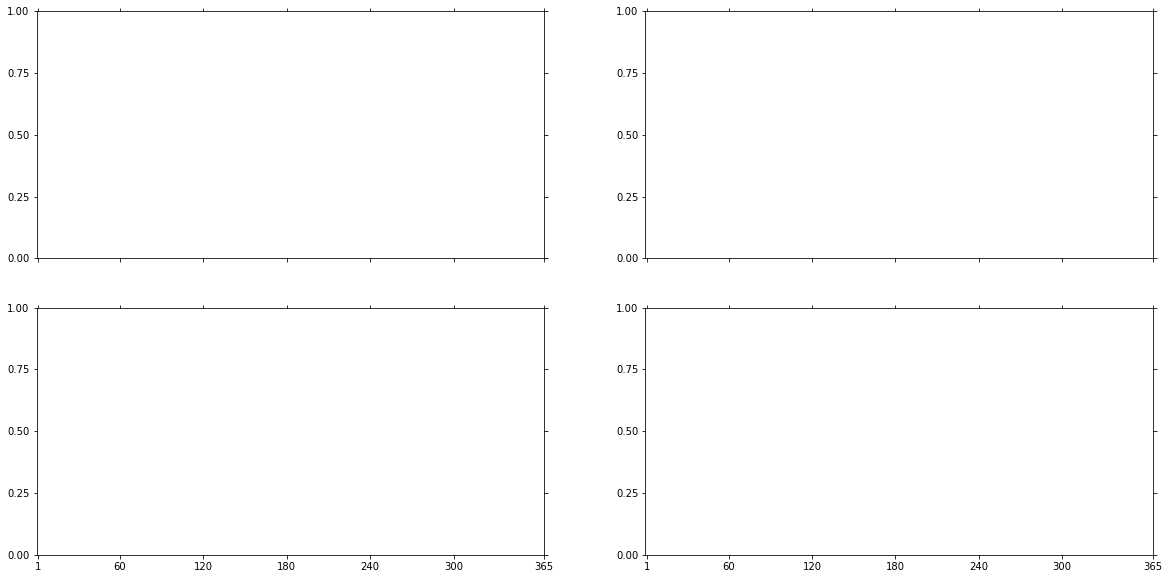

In [116]:
numcols = 2
f1, (ax1, ax2) = plt.subplots(2, numcols, sharex='col')#, sharey='row')


plt.setp((ax1, ax2), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2):
    for i in range(numcols):
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=True, right=True)

# PLOTTING


# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']
alphas = [1., 0.8, 0.6, 0.4]
lws = [2, 2.5, 4, 5.5]

timedays_ly = timedays[1:366]


dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15

culr=['red','blue']

## PHYSICS ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def modelforcingplot(muplot, ms, gs, fig, ax1, ax2):
    
    x = muplot
    muplot = 0
    
    numcols = 2
    
    f1, (ax1, ax2) = plt.subplots(2, numcols, sharex='col')#, sharey='row')


    plt.setp((ax1, ax2), xticks=[1,60,120,180,240,300,365])
    from matplotlib.ticker import MaxNLocator
    for axe in (ax1, ax2):
        for i in range(numcols):
            axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
            axe[i].tick_params(top=True, right=True)

    # PLOTTING


    # color vectors
    #colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
    colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']
    alphas = [1., 0.8, 0.6, 0.4]
    lws = [2, 2.5, 4, 5.5]

    timedays_ly = timedays[1:366]


    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15

    culr=['red','blue']

    
    
    ax2[muplot].set_xlabel('Day in year')
    ax2[muplot+1].set_xlabel('Day in year')
    
    N_Max = 10  # np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) + np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) * 0.1
  
    NOX = ms.physics.forcing.NOX.return_interpvalattime(timedays_ly)
    NOXdat = ms.physics.forcing.NOX.forcingfile
    
    
    MLD = ms.physics.forcing.MLD.return_interpvalattime(timedays_ly)
    MLDdat = ms.physics.forcing.MLD.forcingfile
    MLD_max = 250 #np.max(MLD) + 0.1 * np.max(MLD)
    #print(NOX)
    #print(NOXdat)
    
    par1 = ax1[muplot+1]

    par1.plot(timedays_ly, NOX, culr[x], lw=lws[0], alpha=alphas[0])
    par1.scatter(dpm_cumsum, NOXdat[0:12], c=culr[x])
    if x == 1:
        par1.set_ylabel('$N_0$ \n' '[µM]', multialignment='center', fontsize=10)
    par1.set_ylim(0., N_Max)
    #ax1[muplot].invert_yaxis()

    ax1[muplot].plot(timedays_ly, MLD, culr[x], lw=lws[0], alpha=alphas[0])
    ax1[muplot].scatter(dpm_cumsum, MLDdat[0:12], c=culr[x])
    if x == 0:
        ax1[muplot].set_ylabel('MLD \n' '[m]', multialignment='center', fontsize=10)
    ax1[muplot].set_ylim(0, MLD_max) # 400 for biotrans, 100 for Papa
    ax1[muplot].invert_yaxis()
    
    par1.yaxis.tick_right()
    par1.yaxis.set_ticks_position('both')
    par1.yaxis.set_label_position("right")
    
    tkw = dict(size=4, width=1.5)
    par1.tick_params(direction="in", axis='y', **tkw)
    #par1.yaxis.label.set_color('b')
    #par1.spines['right'].set_edgecolor('b')
   
    ax1[muplot].tick_params(direction='in',**tkw)
    par1.tick_params(direction='in',**tkw)
    
    ax1[muplot].tick_params(direction="in", axis='y', **tkw)
    #ax1[muplot].yaxis.label.set_color('r')
    #ax1[muplot].spines['left'].set_color('r')
    
    ##################################
    
    
    PAR = ms.physics.forcing.PAR.return_interpvalattime(timedays_ly)
    PARdat = ms.physics.forcing.PAR.forcingfile
    PAR_max = 55  # np.max(PAR) + 0.1 * np.max(PAR)
    
    Tmld = ms.physics.forcing.SST.return_interpvalattime(timedays_ly)
    Tmlddat = ms.physics.forcing.SST.forcingfile
    Tmld_max = 40  # np.max(Tmld) + 0.1 * np.max(Tmld)

    
    par2 = ax2[muplot+1]
    
    ax2[muplot].plot(timedays_ly, PAR, culr[x], lw=lws[0], alpha=alphas[0])
    ax2[muplot].scatter(dpm_cumsum, PARdat[0:12], c=culr[x])
    if x == 0:
        ax2[muplot].set_ylabel('PAR \n' '[E $m^{−2}$ $s^{−1}$]', multialignment='center', fontsize=10)
    ax2[muplot].set_ylim(0, PAR_max)
    # ax1[muplot].invert_yaxis()
    

    par2.plot(timedays_ly, Tmld, culr[x], lw=lws[0], alpha=alphas[0])
    par2.scatter(dpm_cumsum, Tmlddat[0:12], c=culr[x])
    if x == 1:
        par2.set_ylabel('$T_{MLD}$ \n' '[°C]', multialignment='center', fontsize=10)
    par2.set_ylim(0, Tmld_max)
    par2.yaxis.tick_right()
    par2.yaxis.set_ticks_position('both')
    par2.yaxis.set_label_position("right")
    
        
    tkw = dict(size=4, width=1.5)
    par2.tick_params(direction="in", axis='y', **tkw)
    #par2.yaxis.label.set_color('orange')
    #par2.spines['right'].set_edgecolor('orange')
   
    ax2[muplot].tick_params(direction='in',**tkw)
    par2.tick_params(direction='in',**tkw)
    
    ax2[muplot].tick_params(direction="in", axis='y', **tkw)
    #ax2[muplot].yaxis.label.set_color('y')
    #ax2[muplot].spines['left'].set_color('y')
    
    #ax1[muplot+1].yaxis.set_major_formatter(plt.NullFormatter())
    #ax2[muplot+1].yaxis.set_major_formatter(plt.NullFormatter())
    return [ax1, ax2]
        
#modelforcingplot(0, ms1)
#modelforcingplot(1, ms2)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2), xlim=xlim)

f1.align_ylabels()

plt.subplots_adjust(hspace=0)

plt.tight_layout()

#plt.savefig('modelforcing.png')
plt.show()


In [ ]:
# extra code (not used)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cartopy.crs as ccrs

desired_projections = [ccrs.PlateCarree(),
                       ccrs.RotatedPole(pole_latitude=45, pole_longitude=180)]

for plot_num, desired_proj in enumerate(desired_projections):

    ax = plt.subplot(2, 1, plot_num + 1, projection=desired_proj)

    ax.set_global()

    ax.add_patch(mpatches.Rectangle(xy=[-70, -45], width=90, height=90,
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree())
                 )

    ax.add_patch(mpatches.Rectangle(xy=[70, -45], width=90, height=90,
                                    facecolor='red',
                                    alpha=0.2,
                                    transform=ccrs.Geodetic())
                 )

    ax.gridlines()
    ax.coastlines()
    
plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='gray', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

    
ax.add_patch(mpatches.Rectangle(xy=loc_trop, width=rbb, height=rbb,
                                    facecolor='red',
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree())
                 )

ax.add_patch(mpatches.Rectangle(xy=loc_temp, width=rbb, height=rbb,
                                    facecolor='blue',
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree())
                 )


ax.set_xlim((-20, 60))
ax.set_ylim((-40, 40))

plt.show()
